[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
=== Regression Results ===
                            OLS Regression Results                            
Dep. Variable:           S&P500_Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.770e+05
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:00:23   Log-Likelihood:                 10101.
No. Observations:                3253   AIC:                        -2.019e+04
Df Residuals:                    3247   BIC:                        -2.015e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t  

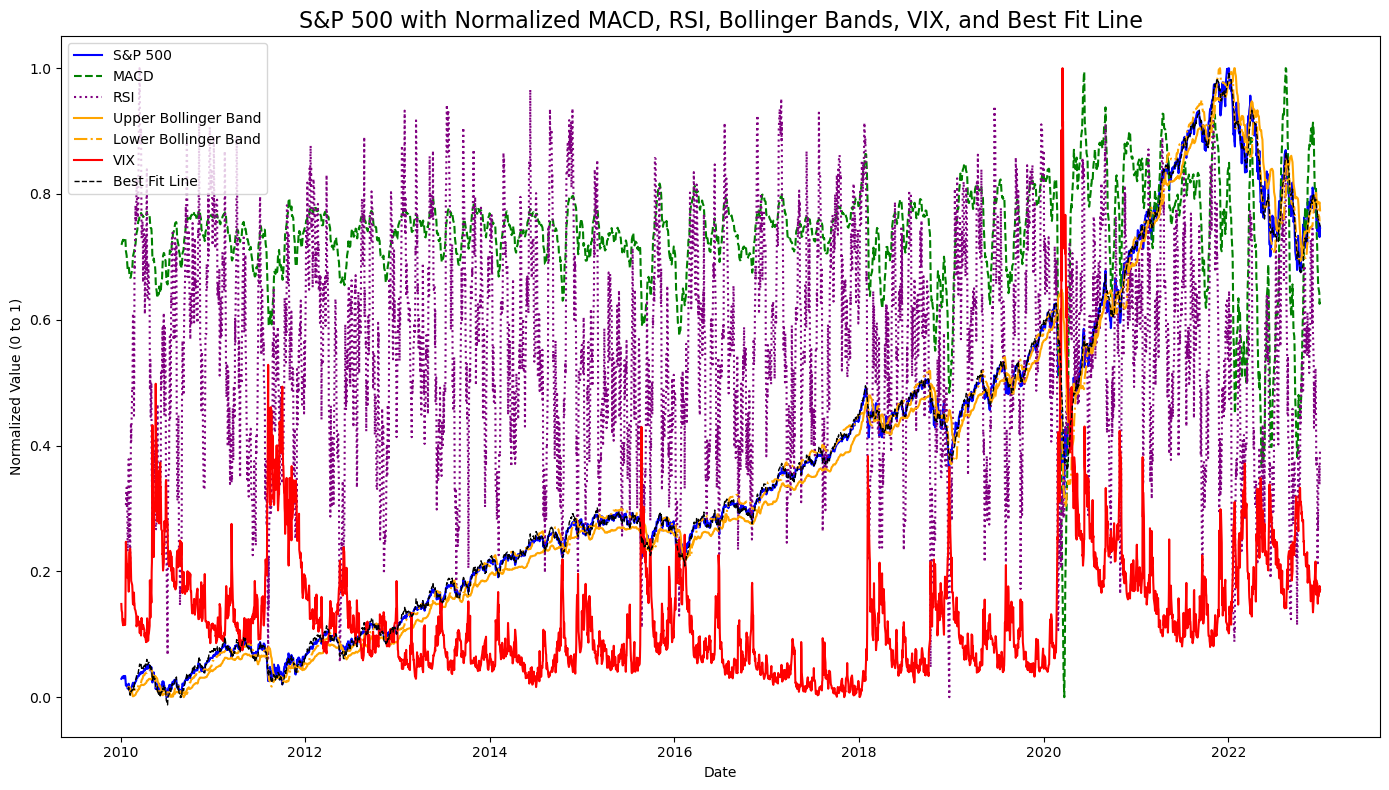

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-01-01')
vix = yf.download('^VIX', start='2010-01-01', end='2023-01-01')

# Calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

sp500['MACD'], sp500['Signal Line'] = calculate_macd(sp500)

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

sp500['RSI'] = calculate_rsi(sp500)

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, std_factor=2):
    sma = data['Close'].rolling(window).mean()
    std = data['Close'].rolling(window).std()
    upper_band = sma + (std_factor * std)
    lower_band = sma - (std_factor * std)
    return upper_band, lower_band

sp500['Upper Band'], sp500['Lower Band'] = calculate_bollinger_bands(sp500)

# Normalization Function (Min-Max Normalization To Bring Data Between 0 And 1)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize All The Indicators And S&P 500 Closing Price
sp500['Normalized_Close'] = normalize(sp500['Close'])
sp500['Normalized_MACD'] = normalize(sp500['MACD'])
sp500['Normalized_RSI'] = normalize(sp500['RSI'])
sp500['Normalized_Upper_Band'] = normalize(sp500['Upper Band'])
sp500['Normalized_Lower_Band'] = normalize(sp500['Lower Band'])
vix['Normalized_VIX'] = normalize(vix['Close'])

# Prepare The Data For Linear Regression
df = pd.DataFrame({
    'S&P500_Close': sp500['Normalized_Close'],
    'MACD': sp500['Normalized_MACD'],
    'RSI': sp500['Normalized_RSI'],
    'Upper_Band': sp500['Normalized_Upper_Band'],
    'Lower_Band': sp500['Normalized_Lower_Band'],
    'VIX': vix['Normalized_VIX']
}).dropna()

# Define The Independent (X) And Dependent (Y) Variables
X = df[['MACD', 'RSI', 'Upper_Band', 'Lower_Band', 'VIX']]
Y = df['S&P500_Close']

# Add A Constant To The Independent Variables (For The Intercept)
X = sm.add_constant(X)

# Perform Linear Regression Using Statsmodels
model = sm.OLS(Y, X).fit()

# Output The Regression Results
print("=== Regression Results ===")
print(model.summary())

# Plot All The Normalized Data And The Best Fit Line
plt.figure(figsize=(14, 8))

# Plot S&P 500
plt.plot(sp500.index, sp500['Normalized_Close'], label='S&P 500', color='blue', linewidth=1.5)

# Plot MACD
plt.plot(sp500.index, sp500['Normalized_MACD'], label='MACD', color='green', linestyle='--')

# Plot RSI
plt.plot(sp500.index, sp500['Normalized_RSI'], label='RSI', color='purple', linestyle=':')

# Plot Bollinger Bands (upper and lower)
plt.plot(sp500.index, sp500['Normalized_Upper_Band'], label='Upper Bollinger Band', color='orange', linestyle='-')
plt.plot(sp500.index, sp500['Normalized_Lower_Band'], label='Lower Bollinger Band', color='orange', linestyle='-.')

# Plot VIX
plt.plot(vix.index, vix['Normalized_VIX'], label='VIX', color='red', linestyle='-')

# Plot The Best Fit Line From The Regression Model
plt.plot(df.index, model.fittedvalues, label='Best Fit Line', color='black', linestyle='--', linewidth=1)

# Add Title And Labels
plt.title('S&P 500 with Normalized MACD, RSI, Bollinger Bands, VIX, and Best Fit Line', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Normalized Value (0 to 1)')

# Adding legend
plt.legend(loc="upper left")

# Show The Plot
plt.tight_layout()
plt.show()
